In [1]:
import json
import pandas as pd
import numpy as np
import re
from collections import Counter
import string
import matplotlib.pyplot as plt
from pylab import rcParams
plt.style.use('ggplot')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Most of the columns are mostly null or not  very informative. We are going to have to drop a bunch of them.

In [3]:
# Get dirty with the columns

with open('trump_tweets_oct11.json') as data_file:    
    data = json.load(data_file)

tweets = pd.read_json(json.dumps(data))

In [6]:
tweets['retweeted_status'].isnull().value_counts()

True     3574
False     171
Name: retweeted_status, dtype: int64

In [7]:
tweets['retweet_count'].astype(int)

#extract device type
tweets.loc[:, 'device'] = tweets['source'] \
.apply(lambda x : 'android' if 'android' in x.lower() else ('iphone' if 'iphone' in x.lower() else 'other'))

#extract time information
est = pd.to_datetime(tweets['created_at']).dt.tz_localize('UTC').dt.tz_convert('US/Eastern')

tweets.loc[:,'hour'] = est.dt.hour
tweets.loc[:,'day'] = est.dt.dayofweek
tweets.loc[:,'month'] = est.dt.month
tweets.loc[:,'year'] = est.dt.year
tweets.loc[:,'morning'] = tweets['hour'].apply(lambda x : 1 if x in range(4,11) else 0)
tweets.loc[:,'evening'] = tweets['hour'].apply(lambda x : 1 if x in range(12,24) else 0)


                                                                      
#extract entities
tweets.loc[:,'numHashtags'] = tweets['entities'].apply(lambda x : len(x['hashtags']))
tweets.loc[:,'numMentions'] = tweets['entities'].apply(lambda x : len(x['user_mentions']))
tweets.loc[:,'numMedia'] = tweets['entities'].apply(lambda x : len(x['media']) if 'media' in x.keys() else 0)
tweets.loc[:,'hasPlace'] = tweets['place'].isnull().astype(int)
tweets.loc[:,'hasUrls'] = tweets.entities.apply(lambda x : len(x['urls']))

#dummy code the possibly_sensitive column                                                       
tweets = tweets.join(pd.get_dummies(tweets['possibly_sensitive'],prefix='possibly_sensitive', dummy_na=True))                                                                               

In [8]:
#prepare emotions dictionary
with open('NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt') as data_file:    
    data = data_file.read()

nrcList = data[data.find("aback"):].split('\n')
sentimentList = pd.DataFrame([i.split('\t') for i in nrcList[:-1]])
sentimentList[2] = sentimentList[2].astype(float)
emotion = {k: g[0].tolist() for k,g in sentimentList[sentimentList[2] > 0].groupby(1)}

In [9]:
# clean up the tweet text
# label the sentiments in each tweets

def cleanify(x):
    new =  re.sub(r"[\$@#\?\!,\-:\"\'\.\\(\\)]","", x.lower())
    new =  re.sub(r"[^\x00-\x7F]+","", new)
    return set(new.split())

tweets['cleantweets'] = tweets['text'].apply(lambda x : cleanify(x))

for i in emotion.keys():
    tweets[i] = tweets['cleantweets'].apply(lambda x : len(x.intersection(set(emotion[i])))/float(len(x)))

# add column with the number of adjectives in it.
from nltk.corpus import wordnet as wn
adjectives = {x.name().split('.', 1)[0] for x in wn.all_synsets('a')}
tweets.loc[:,'numAdjectives'] = tweets.cleantweets.apply(lambda x : len(x.intersection(adjectives)))

In [10]:
#from the previous work, get the top iphone words and the top android words.

iphonetopwords = [u'#americafirst', u'join', u'#trump2016', u'tomorrow',
       u'#makeamericagreatagain', u'#votetrump', u'#maga', u'&amp', u'support',
       u'iowa', u'carolina', u'poll', u'see', u'tonight', u'america',
       u'speech', u'campaign', u'enjoy']

liph = float(len(iphonetopwords))

androidtopwords =  [u'amazing', u'vote', u'watch', u'night', u'clinton', u'debate',
       u'interviewed', u'love', u'been', u'people', u'donald', u'rubio',
       u'obama', u'time', u'job', u'@foxnews', u'jobs', u'country', u'cruz',
       u'hillary', u'trump', u'president', u'ted', u'win', u'bad', u'media',
       u'wow', u'bernie', u'crooked', u'republican', u'@cnn',
       u'@realdonaldtrump']

landr = float(len(androidtopwords))

In [14]:
#Get the proportion of top iphone words and top android words for each tweet

tweets['androidwords'] = tweets['cleantweets'].apply(lambda x : len(x.intersection(set(androidtopwords)))/landr)
tweets['iphonewords'] = tweets['cleantweets'].apply(lambda x : len(x.intersection(set(iphonetopwords)))/ liph)

#check if the tweet contains 'rt'
tweets['rt'] = tweets.cleantweets.apply(lambda x : 1 if 'rt' in x else 0)
tweets['quotes'] = tweets.text.apply(lambda x : 1 if '"' in x else 0)

In [31]:
#Put together final list of columns to use in the model

goodCols = [u'favorite_count', u'retweet_count']
meany = goodCols + list(tweets.columns[33:].values) + ['device']

extracols = ['cleantweets', 'month','year','rt']

finalCols = [x for x in meany if x not in extracols]

andIph = tweets[tweets['device'] != 'other'][finalCols]
andIph.head()





,favorite_count,retweet_count,hour,day,morning,evening,numHashtags,numMentions,numMedia,hasPlace,...,positive,anger,surprise,fear,trust,numAdjectives,androidwords,iphonewords,quotes,device
0,8875,2603,8,2,1,0,0,0,0,1,...,0.260870,0.000000,0.043478,0,0.086957,5,0.09375,0.000000,0,android
1,3012,884,8,2,1,0,0,2,0,1,...,0.062500,0.062500,0.062500,0,0.062500,3,0.03125,0.000000,0,android
2,2358,808,8,2,1,0,0,1,0,1,...,0.000000,0.041667,0.000000,0,0.000000,4,0.03125,0.000000,0,android
3,5840,2053,8,2,1,0,0,0,0,1,...,0.076923,0.000000,0.076923,0,0.153846,3,0.03125,0.055556,0,android
4,3489,1129,9,2,1,0,0,1,0,1,...,0.066667,0.000000,0.000000,0,0.000000,3,0.06250,0.055556,0,android


In [37]:
#bad = list(features.index[:11].values) + ["device"]

roc:  0.94307704877
accuracy:  0.881021783818
f1:  0.892110813813
precision:  0.847061457727
recall:  0.945571711831


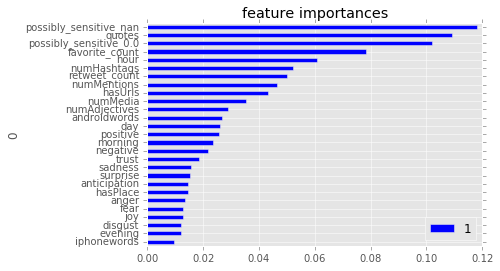

In [32]:
# run random forest model

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  RandomForestClassifier
from sklearn.model_selection import cross_val_score


X = andIph[andIph.columns[:-1]]
#X = andIph[[i for i in andIph.columns if i not in bad]]
y = andIph['device'].apply(lambda x : 1 if x =='android' else 0)

clf = RandomForestClassifier(n_estimators=50, random_state=10)

print "roc: ", cross_val_score(clf, X, y, cv = 5, scoring='roc_auc').mean()
print "accuracy: ", cross_val_score(clf, X, y, cv = 5).mean()
print "f1: ", cross_val_score(clf, X, y, cv = 5, scoring='f1').mean()
print "precision: ", cross_val_score(clf, X, y, cv = 5, scoring='precision').mean()
print "recall: ", cross_val_score(clf, X, y, cv = 5, scoring='recall').mean()

clf = clf.fit(X, y)

#get the feature importances
features = zip(X.columns,clf.feature_importances_)
features.sort(key = lambda x : x[1])
features = pd.DataFrame(features).set_index(0)
plt.figure()
features.plot.barh(title='feature importances')
plt.savefig("featureimportances.png")




In [39]:
# get the other tweets for classification
othertweets = tweets[~tweets['device'].isin(['android','iphone'])][finalCols[:-1]]

#make a dataframe of the the class probabilities and class assignments and the corresponding tweet text
otherclasses = tweets[['text']].loc[othertweets.index]
otherclasses['probabilities'] = clf.predict_proba(othertweets)[:,1]
otherclasses['classes'] = clf.predict(othertweets)
otherclasses['trump or not'] = otherclasses['classes'].apply(lambda x : "trump" if x == 1 else "not trump")
otherclasses.to_csv('tweetclassification.csv',encoding='utf-8')

otherclasses.head()

,text,probabilities,classes,trump or not
20,#MakeAmericaGreatAgain I will be in Cedar Rapi...,0.06,0,not trump
26,.@CharlesHurt Thanks for defending me so bril...,0.76,1,trump
27,.@MelindaDC Don’t misrepresent in order to ma...,0.46,0,not trump
28,I have an idea for @JebBush whose campaign is ...,0.42,0,not trump
29,Weak &amp; ineffective @JebBush is doing ads w...,0.46,0,not trump


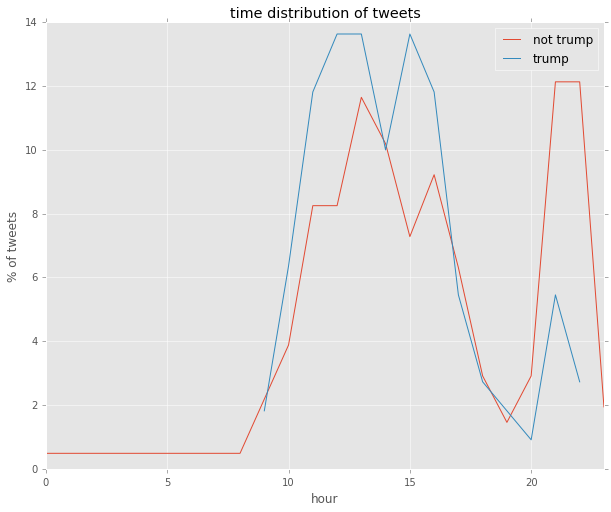

In [40]:
# plot percent tweets for each device
otherhours =  pd.concat([tweets.loc[otherclasses.index,'hour'],otherclasses['trump or not']],axis =1)
grouped = otherhours.groupby(['trump or not', 'hour'])

#get the number of tweets per device per , then get the percentages
numtweets = grouped.size()
#print numtweets.head()

percentTimes = numtweets.groupby(level=[0]).apply(lambda x : 100* x / x.sum()).reset_index()

fig, ax = plt.subplots(figsize=(10,8))

for device, frame in percentTimes.groupby('trump or not'):
    frame.plot.line(x = 'hour', y = 0, ax = ax,label=device, title ="time distribution of tweets")

ax.set_ylabel('% of tweets')
plt.savefig("othertweettimes.png")

# Below are just some cells of me playing around with different models.

In [28]:
# try logistic regression model

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

print "roc: ", cross_val_score(clf, X, y, cv = 5, scoring='roc_auc').mean()
print "accuracy: ", cross_val_score(clf, X, y, cv = 5).mean()
print "f1: ", cross_val_score(clf, X, y, cv = 5, scoring='f1').mean()
print "precision: ", cross_val_score(clf, X, y, cv = 5, scoring='precision').mean()
print "recall: ", cross_val_score(clf, X, y, cv = 5, scoring='recall').mean()

roc:  0.901720162909
accuracy:  0.820385418658
f1:  0.836774895932
precision:  0.794617052816
recall:  0.884500991408


In [21]:
# run gradient boosted model

from sklearn import ensemble

#X = andIph[andIph.columns[:-1]]
#y = andIph['device'].apply(lambda x : 1 if x =='android' else 0)

params = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
clf = ensemble.GradientBoostingClassifier(**params)

print "roc: ", cross_val_score(clf, X, y, cv = 5, scoring='roc_auc').mean()
print "accuracy: ", cross_val_score(clf, X, y, cv = 5).mean()
print "f1: ", cross_val_score(clf, X, y, cv = 5, scoring='f1').mean()
print "precision: ", cross_val_score(clf, X, y, cv = 5, scoring='precision').mean()
print "recall: ", cross_val_score(clf, X, y, cv = 5, scoring='recall').mean()

roc:  0.950192557728
accuracy:  0.875776942266
f1:  0.887020732086
precision:  0.845809518525
recall:  0.936046328644


In [ ]:
# try some feature selection

from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2


feature_filter = SelectKBest(f_classif, k=15)
clf = RandomForestClassifier(n_estimators=50)
anova_svm = Pipeline([('filter', feature_filter), ('rf', clf)])

print "roc: ", cross_val_score(anova_svm, X, y, cv = 5, scoring='roc_auc').mean()
print "accuracy: ", cross_val_score(anova_svm, X, y, cv = 5).mean()
print "f1: ", cross_val_score(anova_svm, X, y, cv = 5, scoring='f1').mean()
print "precision: ", cross_val_score(anova_svm, X, y, cv = 5, scoring='precision').mean()
print "recall: ", cross_val_score(anova_svm, X, y, cv = 5, scoring='recall').mean()


# Experimenting with a sample confusion matrix and roc curve for an idea on how the model is doing

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf = clf.fit(X_train, y_train)

print confusion_matrix(y_test, clf.predict(X_test))

y_pred = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.style.use('ggplot')
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title('ROC curve')
plt.show()